<a href="https://colab.research.google.com/github/ni-metre/Colab_Triplet_Loss_Backup/blob/master/SinglePred_DodecanetRep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Set up gspread
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [2]:
% xmode verbose

Exception reporting mode: Verbose


In [3]:

#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Force a remount of the  drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
# import the necessary packages
import warnings

warnings.filterwarnings("ignore")


import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import glob
import random

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()




import os
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution1D, MaxPooling1D,ZeroPadding1D
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Add, Subtract
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from numpy import array
from sklearn.decomposition import PCA


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

import datetime
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
#from Max_ML3 import prep_data, div_data, div_split_data, run_model, run_multi_model, run_experiment, concatenate_timeseries_and_static_features_list

import pickle
from tensorflow.keras.backend import sum as ksum
from tensorflow.keras.backend import square as ksquare
from tensorflow.keras.backend import mean as kmean
from tensorflow.keras.backend import maximum as kmaximum
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import time


from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import bokeh.io

from bokeh.models import ColumnDataSource, HoverTool, Label, TextAreaInput
from bokeh.models.tools import HoverTool

from bokeh.palettes import viridis, Turbo256
from bokeh.transform import factor_cmap
from bokeh.layouts import row as brow




## 0) Import Metadata

#### Below enter the path name of the test_output files

In [5]:
sensor_of_interest = 15

#path to fake data
path = '/content/drive/My Drive/V3_Fakes/V3_Fake_5pCO2_' + str(sensor_of_interest)

pickle_path = '/content/drive/My Drive/Pickles'

#path to model checkpoints
checkpoint_path = '/content/drive/My Drive/Checkpoints'

#path to real data
real_path = '/content/drive/My Drive/Test_outputs/jdata_9750'

## 1) Defining the sets of 9 tests

#### **get_test_list** returns a list of tests that meet ALL of the criteria defined in the arguments:
#### - Acetone can be a specific value, 'all', '>(value)' or '<(value)'
#### -  CO2 can be 4 (for 40000 - 46666), 5 (for 46667 - 53333), 6 (for 53334 - 60000), 'all' or '+' for CO@ values that are > 0
#### - H2O must be a specific value, always 10 for tests of interest
#### - Sensor can be a specific sensor number or 'all'
#### - Range1 and Range2 are the lower and upper limits for the range of tests of interest from (range1) to (range2 - 1)




In [ ]:
def get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    filtered = filtered.query('FLAG ==""')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
    #return(filtered)

## 2) Reading in and preprocessing the data

# **START HERE TO READ IN A PICKLE VERSION OF ttvdict**!!!!! 

In [23]:
with open(pickle_path +'/ttvdict_dodecanet_combo10_50_24n_v3_7500_csvs_sensor_metadata_peaks.pickle', 'rb') as handle:
    
    ttvdict = pickle.load(handle)
cdict = {'c1_list': ttvdict['paddedc1'], 'c2_list': ttvdict['paddedc2'], 'c3_list': ttvdict['paddedc3'], 'c4_list': ttvdict['paddedc4'], 'c5_list': ttvdict['paddedc5'], 'c6_list': ttvdict['paddedc6'], 'c7_list': ttvdict['paddedc7'], 'c8_list': ttvdict['paddedc8'],'c9_list': ttvdict['paddedc9'],
         'c10_list':ttvdict['paddedc10'], 'c11_list': ttvdict['paddedc11'], 'c12_list': ttvdict['paddedc12']}

In [24]:
#Function to unpack dictionary to list
def unpack_dict(ttvdict):
    vlist = []
    for k,v in ttvdict.items():
        vlist.append(ttvdict[k] )
    return vlist

vlist = unpack_dict(ttvdict)
print(ttvdict.keys())

dict_keys(['c1num', 'c2num', 'c3num', 'c4num', 'c5num', 'c6num', 'c7num', 'c8num', 'c9num', 'c10num', 'c11num', 'c12num', 'paddedc1', 'paddedc2', 'paddedc3', 'paddedc4', 'paddedc5', 'paddedc6', 'paddedc7', 'paddedc8', 'paddedc9', 'paddedc10', 'paddedc11', 'paddedc12', 'c1Ac', 'c2Ac', 'c3Ac', 'c4Ac', 'c5Ac', 'c6Ac', 'c7Ac', 'c8Ac', 'c9Ac', 'c10Ac', 'c11Ac', 'c12Ac', 'c1co2', 'c2co2', 'c3co2', 'c4co2', 'c5co2', 'c6co2', 'c7co2', 'c8co2', 'c9co2', 'c10co2', 'c11co2', 'c12co2', 'c1temp', 'c2temp', 'c3temp', 'c4temp', 'c5temp', 'c6temp', 'c7temp', 'c8temp', 'c9temp', 'c10temp', 'c11temp', 'c12temp', 'c1metadata', 'c2metadata', 'c3metadata', 'c4metadata', 'c5metadata', 'c6metadata', 'c7metadata', 'c8metadata', 'c9metadata', 'c10metadata', 'c11metadata', 'c12metadata', 'c1peak_pos', 'c2peak_pos', 'c3peak_pos', 'c4peak_pos', 'c5peak_pos', 'c6peak_pos', 'c7peak_pos', 'c8peak_pos', 'c9peak_pos', 'c10peak_pos', 'c11peak_pos', 'c12peak_pos', 'c1peak_pos_t', 'c2peak_pos_t', 'c3peak_pos_t', 'c4peak_

# Define the Siamese Model class to run duplicates

In [25]:
class SiameseModel(object):
  def __init__(self, epoch_size, batch_size, embedding_size, vlist_, scale_factor, make_summary ):
    self.epoch_size = epoch_size
    self.batch_size = batch_size
    self.embedding_size = embedding_size
    self.vlist_ = vlist_
    self.scale_factor = scale_factor
    self.make_summary = make_summary

#Splits the data into training, validation, and test lits
  def prep_data(self):
    tvt= train_test_split(*self.vlist_,test_size =0.25)
    print(len(tvt))

    train_list = tvt[::2]
    val_and_test_list = tvt[1::2]
    print(len(val_and_test_list))

    vt = train_test_split(*val_and_test_list,test_size =0.5)

    val_list = vt[::2]
    test_list = vt[1::2]
    print(len(test_list))
      # Assigns test, train, validation data to appropriate dictionary; preps X input data to appropriate shape for 1D convolutions

    self.X_source_test_dict = defaultdict(list)
    self.X_source_train_dict = defaultdict(list)
    self.X_source_val_dict = defaultdict(list)

    self.X_test_dict = defaultdict(list)
    self.X_train_dict = defaultdict(list)
    self.X_val_dict = defaultdict(list)

    self.X_meta_test_dict = defaultdict(list)
    self.X_meta_train_dict = defaultdict(list)
    self.X_meta_val_dict = defaultdict(list)

    self.Y_a_train_dict = defaultdict(list)
    self.Y_c_train_dict = defaultdict(list)
    self.Y_t_train_dict = defaultdict(list)


    self.Y_a_val_dict = defaultdict(list)
    self.Y_c_val_dict = defaultdict(list)
    self.Y_t_val_dict = defaultdict(list)


    self.Y_a_test_dict = defaultdict(list)
    self.Y_c_test_dict = defaultdict(list)
    self.Y_t_test_dict = defaultdict(list)

    self.X_pp_train_dict = defaultdict(list)
    self.X_ppt_train_dict = defaultdict(list)
    self.X_pn_train_dict = defaultdict(list)
    self.X_pnt_train_dict = defaultdict(list)

    self.X_pp_val_dict = defaultdict(list)
    self.X_ppt_val_dict = defaultdict(list)
    self.X_pn_val_dict = defaultdict(list)
    self.X_pnt_val_dict = defaultdict(list)

    self.X_pp_test_dict = defaultdict(list)
    self.X_ppt_test_dict = defaultdict(list)
    self.X_pn_test_dict = defaultdict(list)
    self.X_pnt_test_dict = defaultdict(list)



    for i in range(0, len(cdict)):
        subi = i +1

        self.X_source_train_dict['X_c' + str(subi)+ '_s_train'] = np.array(train_list[i])
        self.X_source_val_dict['X_c' + str(subi)+ '_s_val'] = np.array(val_list[i ])
        self.X_source_test_dict['X_c' + str(subi)+ '_s_test'] = np.array(test_list[i ])

        self.X_train_dict['X_c' + str(subi)+ '_train'] = np.squeeze(train_list[i + 1*len(cdict)])[...,np.newaxis]
        self.X_val_dict['X_c' + str(subi)+ '_val'] = np.squeeze(val_list[i+ 1*len(cdict)])[...,np.newaxis]
        self.X_test_dict['X_c' + str(subi)+ '_test'] = np.squeeze(test_list[i+ 1*len(cdict)])[...,np.newaxis]

        #Here you have the option to slice the metadata and just use the parameters you care about
        self.X_meta_train_dict[str(subi)] = np.array(train_list[i + 5*len(cdict)])#[:,:2]
        self.X_meta_val_dict[str(subi)] = np.array(val_list[i + 5*len(cdict)])#[:,:2]
        self.X_meta_test_dict[str(subi)] = np.array(test_list[i + 5*len(cdict)])#[:,:2]


        self.Y_a_train_dict['Y_c' + str(subi)+ '_a_train']= np.array(train_list[i + 2*len(cdict)])
        self.Y_c_train_dict['Y_c' + str(subi)+ '_c_train'] = np.array(train_list[i + 3*len(cdict)])
        self.Y_t_train_dict['Y_c' + str(subi)+ '_t_train'] = np.array(train_list[i + 4*len(cdict)])

        self.Y_a_val_dict['Y_c' + str(subi)+ '_a_val']= np.array(val_list[i + 2*len(cdict)])
        self.Y_c_val_dict['Y_c' + str(subi)+ '_c_val'] = np.array(val_list[i + 3*len(cdict)])
        self.Y_t_val_dict['Y_c' + str(subi)+ '_t_val'] = np.array(val_list[i + 4*len(cdict)])

        self.Y_a_test_dict['Y_c' + str(subi)+ '_a_test']= np.array(test_list[i + 2*len(cdict)])
        self.Y_c_test_dict['Y_c' + str(subi)+ '_c_test'] = np.array(test_list[i + 3*len(cdict)])
        self.Y_t_test_dict['Y_c' + str(subi)+ '_t_test'] = np.array(test_list[i + 4*len(cdict)])


        #Y_bs_train_dict['Y_c' + str(subi)+ '_bs_train'] = train_list[i + 4*len(cdict)]
        #Y_tb_train_dict['Y_c' + str(subi)+ '_tb_train'] = train_list[i + 5*len(cdict)]
        #Y_tco2_train_dict['Y_c' + str(subi)+ '_tco2_train'] = train_list[i + 6*len(cdict)]
        #Y_ttd_train_dict['Y_c' + str(subi)+ '_ttd_train'] = train_list[i + 7*len(cdict)]

        self.X_pp_train_dict[str(subi)]= np.array(train_list[i + 6*len(cdict)])
        self.X_ppt_train_dict[str(subi)]=np.array(train_list[i + 7*len(cdict)])
        self.X_pn_train_dict[str(subi)]=np.array(train_list[i + 8*len(cdict)])
        self.X_pnt_train_dict[str(subi)]=np.array(train_list[i + 9*len(cdict)])


        self.X_pp_val_dict[str(subi)]= np.array(val_list[i + 6*len(cdict)])
        self.X_ppt_val_dict[str(subi)]=np.array(val_list[i + 7*len(cdict)])
        self.X_pn_val_dict[str(subi)]=np.array(val_list[i + 8*len(cdict)])
        self.X_pnt_val_dict[str(subi)]=np.array(val_list[i + 9*len(cdict)])


        self.X_pp_test_dict[str(subi)]= np.array(test_list[i + 6*len(cdict)])
        self.X_ppt_test_dict[str(subi)]=np.array(test_list[i + 7*len(cdict)])
        self.X_pn_test_dict[str(subi)]=np.array(test_list[i + 8*len(cdict)])
        self.X_pnt_test_dict[str(subi)]=np.array(test_list[i + 9*len(cdict)])



        print(i)
        print(self.X_test_dict['X_c' + str(subi)+ '_test'].shape)
        print(self.X_train_dict['X_c' + str(subi)+ '_train'].shape)
        print(self.X_val_dict['X_c' + str(subi)+ '_val'].shape)
        print(len(self.Y_c_train_dict['Y_c' + str(subi)+ '_c_train']))
        print(len(self.Y_a_test_dict['Y_c' + str(subi)+ '_a_test']))
        print(len(self.Y_t_test_dict['Y_c' + str(subi)+ '_t_test']))
        print('metadata')
        print(len(self.X_meta_test_dict[str(subi)]))
        print(self.X_meta_train_dict[str(subi)].shape)

    self.Y_cn_train_dict = defaultdict(list)
    self.Y_cn_test_dict =defaultdict(list)
    self.Y_cn_val_dict = defaultdict(list)


    if self.scale_factor == 'log':
        for i in range(0, len(self.Y_c_train_dict)):
          subi = i + 1
          cn_train_list = []
          for j in range (0, len(self.Y_c_train_dict['Y_c' + str(subi)+ '_c_train'])):
            cn_train = math.log2(self.Y_c_train_dict['Y_c' + str(subi)+ '_c_train'][j])
            cn_train_list.append(cn_train)
          self.Y_cn_train_dict['Y_c' + str(subi)+ '_c_train'] = np.array(cn_train_list)

        for i in range(0, len(self.Y_c_test_dict)):
          subi = i + 1
          cn_test_list = []
          for j in range (0, len(self.Y_c_test_dict['Y_c' + str(subi)+ '_c_test'])):
            cn_test = math.log2(self.Y_c_test_dict['Y_c' + str(subi)+ '_c_test'][j])
            cn_test_list.append(cn_test)
          self.Y_cn_test_dict['Y_c' + str(subi)+ '_c_test'] = np.array(cn_test_list)

        for i in range(0, len(self.Y_c_val_dict)):
          subi = i + 1
          cn_val_list = []
          for j in range (0, len(self.Y_c_val_dict['Y_c' + str(subi)+ '_c_val'])):
            cn_val = math.log2(self.Y_c_val_dict['Y_c' + str(subi)+ '_c_val'][j])
            cn_val_list.append(cn_val)
          self.Y_cn_val_dict['Y_c' + str(subi)+ '_c_val'] = np.array(cn_val_list)


    else:
        for i in range(0, len(self.Y_c_train_dict)):
          subi = i + 1
          cn_train_list = []
          for j in range (0, len(self.Y_c_train_dict['Y_c' + str(subi)+ '_c_train'])):
            cn_train = (self.Y_c_train_dict['Y_c' + str(subi)+ '_c_train'][j])*self.scale_factor
            cn_train_list.append(cn_train)
          self.Y_cn_train_dict['Y_c' + str(subi)+ '_c_train'] = np.array(cn_train_list)

        for i in range(0, len(self.Y_c_test_dict)):
          subi = i + 1
          cn_test_list = []
          for j in range (0, len(self.Y_c_test_dict['Y_c' + str(subi)+ '_c_test'])):
            cn_test = (self.Y_c_test_dict['Y_c' + str(subi)+ '_c_test'][j]*self.scale_factor)
            cn_test_list.append(cn_test)
          self.Y_cn_test_dict['Y_c' + str(subi)+ '_c_test'] = np.array(cn_test_list)

        for i in range(0, len(self.Y_c_val_dict)):
          subi = i + 1
          cn_val_list = []
          for j in range (0, len(self.Y_c_val_dict['Y_c' + str(subi)+ '_c_val'])):
            cn_val = (self.Y_c_val_dict['Y_c' + str(subi)+ '_c_val'][j]*self.scale_factor)
            cn_val_list.append(cn_val)
          self.Y_cn_val_dict['Y_c' + str(subi)+ '_c_val'] = np.array(cn_val_list)


    self.X_p_test_dict = defaultdict(list)
    self.X_p_val_dict = defaultdict(list)
    self.X_p_train_dict = defaultdict(list)

    for i in range(0, len(self.X_pp_test_dict)):
      subi = i + 1
    
      p_test_list = []
      for j in range(0, len(self.X_pp_test_dict[str(subi)])):
         p_test_list.append([self.X_pp_test_dict[str(subi)][j], self.X_ppt_test_dict[str(subi)][j], self.X_pn_test_dict[str(subi)][j], self.X_pnt_test_dict[str(subi)][j]])
      self.X_p_test_dict[str(subi)] = np.array(p_test_list)
    
      p_val_list = []
      for j in range(0, len(self.X_pp_val_dict[str(subi)])):
         p_val_list.append([self.X_pp_val_dict[str(subi)][j], self.X_ppt_val_dict[str(subi)][j], self.X_pn_val_dict[str(subi)][j], self.X_pnt_val_dict[str(subi)][j]])
      self.X_p_val_dict[str(subi)] = np.array(p_val_list)
    
      p_train_list = []
      for j in range(0, len(self.X_pp_train_dict[str(subi)])):
         p_train_list.append([self.X_pp_train_dict[str(subi)][j], self.X_ppt_train_dict[str(subi)][j], self.X_pn_train_dict[str(subi)][j], self.X_pnt_train_dict[str(subi)][j]])
      self.X_p_train_dict[str(subi)] = np.array(p_train_list)
  

  def make_model(self):
    self.prep_data()
    self.input_trace_shape = self.X_train_dict['X_c1_train'].shape[1:]
    print('THIS IS THE INPUT SHAPE' + str(self.input_trace_shape))
    self.input_metadata_shape = self.X_meta_train_dict['1'].shape[1:]
    #input_sensor_shape = X_sensor_train_dict['X_c1_s_train'].shape[1:]
    self.input_peak_shape = self.X_p_train_dict['1'].shape[1:]
  def create_base_network(self, input_trace_shape, embedding_size):
    #def create_base_network(input_trace_shape, input_metadata_shape, embedding_size):
     """
     Base network to be shared (eq. to feature extraction).
     """
     input_trace = Input(shape=input_trace_shape)
     #input_metadata = Input(shape = input_metadata_shape)
     #input_sensor = Input(shape=input_sensor_shape)
     #input_peak = Input(shape = input_peak_shape)
     #peak = BatchNormalization()(input_peak)

     x = Convolution1D(filters = 16, kernel_size = 6, strides = 2, activation='relu')(input_trace)
     x = Convolution1D(filters = 32, kernel_size = 6, strides = 2, activation='relu')(x)
     x = Convolution1D(filters = 64, kernel_size = 6, strides = 2, activation='relu')(x)
     x = Convolution1D(filters = 128, kernel_size = 6, strides = 2, activation='relu')(x)
     #x = Convolution1D(filters = 256, kernel_size = 6, strides = 2, activation='relu')(x)
     x = MaxPooling1D(pool_size=2)(x)
     x = Flatten()(x)
     x = Dense(32, activation='relu')(x)
     x = Dense(32, activation = 'relu')(x)
     #xm = concatenate([x, input_metadata], axis = -1)
     #xm = Dense(32, activation='relu')(xm)
     #xm = Dense(32, activation = 'relu')(xm)
     #embedding = concatenate([x, peak], axis = -1)
     embedding = Dense(embedding_size, activation = 'relu', name = 'single_embedding')(x)

     #embedding_plus_peak = concatenate([embedding, peak], axis = -1)
    # embedding = Dense(embedding_size, activation = 'relu')(embedding_plus_peak)

     #Acetone head
     Ac_head = Dense(32, activation = 'relu', name = 'Ac_head')(embedding)
     Ac_head = Dense(16, activation = 'relu')(Ac_head)
     predAc = Dense(1, activation= 'linear', name = 'Ac_prediction_output')(Ac_head)
      #CO2 head
     #CO2_head = Dense(32, activation='relu', name = 'CO2_head')(embedding)
     #CO2_head = Dense(16, activation = 'relu')(CO2_head)
     #CO2_head = Dense(16, activation = 'relu')(CO2_head)
     #predCO2 = Dense(1, activation= 'linear', name = 'CO2_prediction_output')(CO2_head)

       #Merge the embeddings and predictions as a single ouptut of the form (Acetone_prediction, CO2_prediction, embedding)
     #mergedpred = concatenate([predAc, predCO2], axis = -1)

     #merged = concatenate([mergedpred, embedding], axis = -1)
     base_network = Model(inputs=[input_trace], outputs=[predAc, embedding])

     return base_network

  def run_model(self):
    self.make_model()
    inputdict = defaultdict(list)
    input_peak_dict = defaultdict(list)
    inputshape = self.X_train_dict['X_c1_train'].shape[1:]
    esize = 32

    preds_dict = defaultdict(list)
    embeddings_dict = defaultdict(list)

    base_network = self.create_base_network(input_trace_shape = inputshape, embedding_size = esize)

    for i in range (0, len(cdict)):
        subi = i + 1
        inputdict['input_tracesc' + str(subi)]= Input(shape=inputshape, name = 'input_tracec'+ str(subi))
       # input_peak_dict['input_peakc' + str(subi)]= Input(shape=input_peak_shape, name = 'input_peakc'+ str(subi))


        preds_dict[str(subi)],  embeddings_dict[str(subi)]=  base_network([inputdict['input_tracesc' + str(subi)]])
    inputlist = unpack_dict(inputdict)
    #inputpeaklist = unpack_dict(input_peak_dict)




    #NEED TO CONCATENATE ALL 9 OUTPUTS

    #concatenate all 9 outputs to a single output so it is easy to handle with a custom loss function
    combo_preds = concatenate([*unpack_dict(preds_dict)],axis = -1) 
    combo_embed = concatenate([*unpack_dict(embeddings_dict)],axis = -1) 

    self.model = Model(inputs = [*inputlist], 
                outputs = {"combined_preds":combo_preds,"combined_embedding" :combo_embed})


    if self.make_summary:
      self.model.summary()
      base_network.summary()
      model_name = 'base_network_for concatenate quadruplet loss_single_embedding_single_prediction together'
      plot_model(base_network, show_shapes=True, to_file= model_name + '.png')
    else:
      pass
    def mod_quad_loss(y_true, y_pred):
      alpha = 1.6

      emA = y_pred[:,0:(esize)]
      emB = y_pred[:,((esize)) :(2*(esize))]
      emC = y_pred[:,((esize)*2) :(3*(esize))]
      emD = y_pred[:,((esize)*3) :(4*(esize))]
      emE = y_pred[:,((esize)*4) :(5*(esize))]
      emF = y_pred[:,((esize)*5) :(6*(esize))]
      emG = y_pred[:,((esize)*6) :(7*(esize))]
      emH = y_pred[:,((esize)*7) :(8*(esize))]
      emI = y_pred[:,((esize)*8) :(9*(esize))]
      emJ = y_pred[:,((esize)*9) :(10*(esize))]
      emK = y_pred[:,((esize)*10) :(11*(esize))]
      emL = y_pred[:,((esize)*11) :(12*(esize))]


      c1 = l2_normalize(emA,axis=-1)
      c2 = l2_normalize(emB,axis=-1)
      c3 = l2_normalize(emC,axis=-1)
      c4 = l2_normalize(emD,axis=-1)
      c5 = l2_normalize(emE,axis=-1)
      c6 = l2_normalize(emF,axis=-1)
      c7 = l2_normalize(emG,axis=-1)
      c8 = l2_normalize(emH,axis=-1)
      c9 = l2_normalize(emI,axis=-1)
      c10 = l2_normalize(emJ,axis=-1)
      c11 = l2_normalize(emK,axis=-1)
      c12 = l2_normalize(emL,axis=-1)

      #distance between anchors and postiives
      pos_dist_1 = ksum(ksquare(c1-c2))
      pos_dist_2 = ksum(ksquare(c3-c4))
      pos_dist_3 = ksum(ksquare(c1-c5))
      pos_dist_4 = ksum(ksquare(c1-c2))
      pos_dist_5 = ksum(ksquare(c1-c8))
      pos_dist_6 = ksum(ksquare(c1-c5))
      pos_dist_7 = ksum(ksquare(c1-c2))
      pos_dist_8 =  ksum(ksquare(c1-c8))

      # distance between the anchors and the negatives
      neg_dist_1 = ksum(ksquare(c1-c3))
      neg_dist_2 = ksum(ksquare(c4-c2))
      neg_dist_3 = ksum(ksquare(c1-c6))
      neg_dist_4 = ksum(ksquare(c1-c7))
      neg_dist_5 = ksum(ksquare(c1-c9))
      neg_dist_6 = ksum(ksquare(c1-c10))
      neg_dist_7 = ksum(ksquare(c1-c11))
      neg_dist_8 = ksum(ksquare(c1-c12))

      # compute loss
      basic_loss = (pos_dist_1 + pos_dist_2 + pos_dist_3 + pos_dist_4 +pos_dist_5 + pos_dist_6 + pos_dist_7 + pos_dist_8 ) - (neg_dist_1 + neg_dist_2 + neg_dist_3 + neg_dist_4 + neg_dist_5 + neg_dist_6 + neg_dist_7 + neg_dist_8 ) + alpha
      #loss = kmean(basic_loss)
      tloss = kmaximum(basic_loss,0.0)
      return tloss


    #compiling model
    losses = {
    	"combined_preds": MeanSquaredError(),
    	"combined_embedding": mod_quad_loss
    }
    lossWeights = {"combined_preds": 9.0, "combined_embedding": 1.0}

    #compiling model
    opt = Adam(lr=0.001)  # choose optimiser. RMS is good too!

    self.model.compile(optimizer=opt, loss = losses, loss_weights = lossWeights)  
    dummy_train_dict = defaultdict(list)
    dummy_val_dict = defaultdict(list)
    dummy_test_dict = defaultdict(list)
  
    pred_train_dict = defaultdict(list) 
    pred_val_dict = defaultdict(list) 
    pred_test_dict = defaultdict(list) 
  
    for i in range(0, len(cdict)):
        dummy_train_list = []
        dummy_test_list = []
        dummy_val_list = []
    
        pred_train_list = []
        pred_test_list = []
        pred_val_list = []
    
        subi = i + 1
        for j in range (0, len(self.Y_a_test_dict['Y_c' + str(subi)+ '_a_test'])):
            dummyembed = np.zeros((self.embedding_size))
            twopreds = np.array((self.Y_a_test_dict['Y_c' + str(subi)+ '_a_test'][j]))
            pred_test_list.append(twopreds)
            dummy_test_list.append(dummyembed)
        for k in range (0, len(self.Y_a_train_dict['Y_c' + str(subi)+ '_a_train'])):
            dummyembed = np.zeros((self.embedding_size))
            twopreds = np.array((self.Y_a_train_dict['Y_c' + str(subi)+ '_a_train'][k]))
            pred_train_list.append(twopreds)
            dummy_train_list.append(dummyembed)
        for l in range (0, len(self.Y_a_val_dict['Y_c' + str(subi)+ '_a_val'])):
            dummyembed = np.zeros((self.embedding_size))
            twopreds = np.array((self.Y_a_val_dict['Y_c' + str(subi)+ '_a_val'][l]))
            pred_val_list.append(twopreds)
            dummy_val_list.append(dummyembed)
        dummy_train_dict[i] = np.array(dummy_train_list)
        dummy_test_dict[i] = np.array(dummy_test_list)
        dummy_val_dict[i] = np.array(dummy_val_list)
        
        pred_train_dict[i]= np.array(self.Y_a_train_dict['Y_c' + str(subi)+ '_a_train'][...,np.newaxis])
        pred_val_dict[i] =np.array(self.Y_a_val_dict['Y_c' + str(subi)+ '_a_val'][...,np.newaxis])
        pred_test_dict[i]  =np.array(self.Y_a_test_dict['Y_c' + str(subi)+ '_a_test'][...,np.newaxis])
            
    
    self.dummy_train = concatenate([*unpack_dict(dummy_train_dict)])
    self.dummy_val = concatenate([*unpack_dict(dummy_val_dict)])
            
    self.pred_train = concatenate([*unpack_dict(pred_train_dict)])
    self.pred_val = concatenate([*unpack_dict(pred_val_dict)])   
    #Running model
    
    print('dummy train shape is ', self.dummy_train.shape)
    print('pred train shape is ', self.pred_train.shape)
    #filepath=checkpoint_path + 'checkpoint_model_50epochs' + timestr+ '.hd5'
    #checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='max')
    #callbacks_list = [checkpoint]
    def step_decay(epoch):
       initial_lrate = 0.001
       drop = 0.1
       epochs_drop = 10.0
       lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
       return lrate
    lrate = LearningRateScheduler(step_decay)
    callbacks_list = [lrate]
    
    hist = self.model.fit(
        x=[[*unpack_dict(self.X_train_dict)]],
        y={"combined_preds": self.pred_train, "combined_embedding": self.dummy_train},
        batch_size=self.batch_size,
        epochs=self.epoch_size,
        validation_data=([[*unpack_dict(self.X_val_dict)]], {"combined_preds": self.pred_val, "combined_embedding": self.dummy_val}), verbose =1, 
        
        #callbacks=callbacks_list
        )
    #model.save_weights('model.hdf5')
    plt.figure()
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Training and Validation Losses',size = 20)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    # Test the network by making an untrained copy and then a trained copy of the embedding models


    test_model_dict = defaultdict(list)
    pretrain_ac_dict = defaultdict(list)

    pretrain_embedding_dict = defaultdict(list)
    posttrain_ac_dict = defaultdict(list)

    posttrain_embedding_dict = defaultdict(list)

    fake_test_results_ac = []
    fake_test_results_co2 = []

    for i in range (0, len(cdict)):

        subi = i + 1
        test_model = self.create_base_network(self.input_trace_shape,
                                             embedding_size=self.embedding_size)
        pretrain_pred, pretrain_embedding = test_model.predict([self.X_test_dict['X_c' + str(subi)+ '_test']])
        pretrain_ac_dict[i] = pretrain_pred

        pretrain_embedding_dict[i] = pretrain_embedding

        for layer_target, layer_source in zip(test_model.layers, self.model.layers[len(cdict)*1].layers):
            weights = layer_source.get_weights()
            layer_target.set_weights(weights)
            del weights

        posttrain_pred, posttrain_emebdding = test_model.predict([self.X_test_dict['X_c' + str(subi)+ '_test']])
        posttrain_ac_dict[i] = posttrain_pred

        posttrain_embedding_dict[i] = posttrain_emebdding
    for i in range (0, len(cdict)):
        plt.figure( figsize=(8, 3))
        subi = i + 1
        #axes = plt.gca()
        #axes.set_xlim([0,100])
        #axes.set_ylim([0,100])
        plt.ylabel('Acetone')
        plt.xlabel('Predictions')
        plt.title('MSE is ' + str(round(mean_squared_error(pred_test_dict[i][:,:1], posttrain_ac_dict[i]),4)))
        plt.scatter(posttrain_ac_dict[i], pred_test_dict[i][:,:1], c = 'k' , s = 10)
        fake_test_results_ac.append(round(mean_squared_error(pred_test_dict[i][:,:1], posttrain_ac_dict[i]),4))
    self.real_test_model = self.create_base_network(self.input_trace_shape, 
                                         embedding_size=self.embedding_size)
    #for layer_target, layer_source in zip(real_test_model.layers, model.layers):
    for layer_target, layer_source in zip(self.real_test_model.layers, self.model.layers[len(cdict)*1].layers):
        weights = layer_source.get_weights()
        layer_target.set_weights(weights)
        del weights

    return test_model, fake_test_results_ac

  def run_realdata_check(self, plot_title, real_data_dict):
    # THIS IS TO RUN WITH REAL DATA EMBEDDING
  
    predictions, embeddings =  self.real_test_model.predict([real_data_dict['csvs']])
    real_data_pred_Ac = predictions
   
    ace_mse = mean_squared_error(real_data_dict['Ac'],real_data_pred_Ac)

    plt.figure()
    plt.ylabel('Acetone')
    plt.xlabel('Predictions')
    plt.title(' MSE = ' + str(round(ace_mse,4)) + ' ' + plot_title)
  
    plt.scatter(real_data_pred_Ac, real_data_dict['Ac'])
    plt.show()

    return ace_mse, self.real_test_model

# Here is where we run the model in duplicate (set duplicates with range(0,5) value

In [ ]:
code = '10-50 total CO2 near far'


all_fake_ac = []

realdata_mini_ac = []

realdata_full_ac = []

ac_11252_to_11460 = []

ac_11460_to_11652 = []

ac_11652_to_11748 = []

ac_11951_to_12000 = []

#realdata_mini_ac2 = []
#
#realdata_full_ac2 = []
#
#ac_11252_to_114602 = []
#
#ac_11460_to_116522 = []
#
#ac_11652_to_117482 = []



#all_fake_ac2 = []


for i in range(0, 5):
  if i == 0:
    orderflag = True
  else:
    orderflag = False
  rmodel = SiameseModel(epoch_size = 50, batch_size = 32, embedding_size = 32, vlist_=vlist, scale_factor =1, make_summary = orderflag)
  rep_model, ac_mselist = rmodel.run_model()
  all_fake_ac.append(ac_mselist)

  with open(pickle_path +'/real_data_24_csvs_sensor_metadata_peaks.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, real_model= rmodel.run_realdata_check(code +'_126_sensor24', ddict)
  realdata_mini_ac.append(race)


  with open(pickle_path +'/real_data_24_csvs_sensor_metadata_peaks_ALL.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, real_model = rmodel.run_realdata_check(code +'_500_sensor24', ddict)
  realdata_full_ac.append(race)


  with open(pickle_path +'/real_data_24_11252-11461.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, real_model = rmodel.run_realdata_check(code +'_11252-11460_sensor24', ddict)
  ac_11252_to_11460.append(race)


  with open(pickle_path +'/real_data_24_11461-11652.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, real_model = rmodel.run_realdata_check(code +'_11460-11652_sensor24', ddict)
  ac_11460_to_11652.append(race)

  with open(pickle_path +'/real_data_dict_24_11652-11748.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, real_model = rmodel.run_realdata_check(code +'_11652-11748_sensor24', ddict)
  ac_11652_to_11748.append(race)

  with open(pickle_path +'/real_data_24_11951-12000.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, real_model = rmodel.run_realdata_check(code +'_11951-12000_sensor24', ddict)
  ac_11951_to_12000.append(race)

#################

#  with open(pickle_path +'/real_data_23_csvs_sensor_metadata_peaks.pickle', 'rb') as handle:
#    
#    ddict = pickle.load(handle)
#  race, real_model= rmodel.run_realdata_check(code +'_126_sensor23', ddict, rep_model)
#  realdata_mini_ac2.append(race)
#
#
#  with open(pickle_path +'/real_data_23_csvs_sensor_metadata_peaks_ALL.pickle', 'rb') as handle:
#    
#    ddict = pickle.load(handle)
#  race, real_model = rmodel.run_realdata_check(code +'_500_sensor23', ddict, rep_model)
#  realdata_full_ac2.append(race)
#
#
#  with open(pickle_path +'/real_data_dict_23_11252-11460.pickle', 'rb') as handle:
#    
#    ddict = pickle.load(handle)
#  race, real_model = rmodel.run_realdata_check(code +'_11252-11460_sensor23', ddict, rep_model)
#  ac_11252_to_114602.append(race)
#
#
#  with open(pickle_path +'/real_data_dict_23_11460-11652.pickle', 'rb') as handle:
#    
#    ddict = pickle.load(handle)
#  race, real_model = rmodel.run_realdata_check(code +'_11460-11652_sensor23', ddict, rep_model)
#  ac_11460_to_116522.append(race)
#
#  with open(pickle_path +'/real_data_dict_23_11652-11844.pickle', 'rb') as handle:
#    
#    ddict = pickle.load(handle)
#  race, real_model = rmodel.run_realdata_check(code +'_11652-11844_sensor23', ddict, rep_model)
#  ac_11652_to_117482.append(race)
#

print('Sensor 24 Avg performance on fake ML data Ac ', round(np.mean(np.array(all_fake_ac)),2))
print('Sensor 24 StdError performance on fake ML data Ac ', round(np.std(np.array(all_fake_ac))/np.sqrt(len(all_fake_ac)),2))

print('Sensor 24 Avg performance on 126 real dataset Ac', round(np.mean(np.array(realdata_mini_ac)),2))
print('Sensor 24 StdError performance on 126 real dataset Ac', round(np.std(np.array(realdata_mini_ac))/np.sqrt(len(realdata_mini_ac)),2))

print('Sensor 24 Avg performance on ALL real data Ac', round(np.mean(np.array(realdata_full_ac)),2))
print('Sensor 24 StdError performance on ALL real data Ac', round(np.std(np.array(realdata_full_ac))/np.sqrt(len(realdata_full_ac)),2))

#####

print('Sensor 24 Avg performance on fake ML data Ac 11252_to_11460', round(np.mean(np.array(ac_11252_to_11460)),2))
print('Sensor 24 StdError performance on fake ML data Ac 11252_to_11460', round(np.std(np.array(ac_11252_to_11460))/np.sqrt(len(ac_11252_to_11460)),2))


print('Sensor 24 Avg performance on 126 real dataset Ac 11460_to_11652', round(np.mean(np.array(ac_11460_to_11652)),2))
print('Sensor 24 StdError performance on 126 real dataset Ac 11460_to_11652', round(np.std(np.array(ac_11460_to_11652))/np.sqrt(len(ac_11460_to_11652)),2))


print('Sensor 24 Avg performance on real data Ac 11652-11844', round(np.mean(np.array(ac_11652_to_11748)),2))
print('Sensor 24 StdError performance on real data Ac 11652-11844', round(np.std(np.array(ac_11652_to_11748))/np.sqrt(len(ac_11652_to_11748)),2))


print('Sensor 24 Avg performance on real data Ac _11951-12000', round(np.mean(np.array(ac_11951_to_12000)),2))
print('Sensor 24 StdError performance on real data Ac _11951-12000', round(np.std(np.array(ac_11951_to_12000))/np.sqrt(len(ac_11951_to_12000)),2))

#######
#print('Sensor 23 Avg performance on fake ML data Ac ', round(np.mean(np.array(all_fake_ac2)),2))
#print('Sensor 23 StdError performance on fake ML data Ac ', round(np.std(np.array(all_fake_ac2))/np.sqrt(len(all_fake_ac2)),2))
#
#print('Sensor 23 Avg performance on 126 real dataset Ac', round(np.mean(np.array(realdata_mini_ac2)),2))
#print('Sensor 23 StdError performance on 126 real dataset Ac', round(np.std(np.array(realdata_mini_ac2))/np.sqrt(len(realdata_mini_ac2)),2))
#
#print('Sensor 23 Avg performance on ALL real data Ac', round(np.mean(np.array(realdata_full_ac2)),2))
#print('Sensor 23 StdError performance on ALL real data Ac', round(np.std(np.array(realdata_full_ac2))/np.sqrt(len(realdata_full_ac2)),2))
#
######
#
#print('Sensor 23 Avg performance on fake ML data Ac 11252_to_11460', round(np.mean(np.array(ac_11252_to_114602)),2))
#print('Sensor 23 StdError performance on fake ML data Ac 11252_to_11460', round(np.std(np.array(ac_11252_to_114602))/np.sqrt(len(ac_11252_to_114602)),2))
#
#
#print('Sensor 23 Avg performance on 126 real dataset Ac 11460_to_11652', round(np.mean(np.array(ac_11460_to_116522)),2))
#print('Sensor 23 StdError performance on 126 real dataset Ac 11460_to_11652', round(np.std(np.array(ac_11460_to_116522))/np.sqrt(len(ac_11460_to_116522)),2))
#
#
#print('Sensor 23 Avg performance on real data Ac 11652-11844', round(np.mean(np.array(ac_11652_to_117482)),2))
#print('Sensor 23 StdError performance on real data Ac 11652-11844', round(np.std(np.array(ac_11652_to_117482))/np.sqrt(len(ac_11652_to_117482)),2))
#
#
#

In [10]:
print('Sensor 24 Avg performance on fake ML data Ac ', round(np.mean(np.array(all_fake_ac)),2))
print('Sensor 24 StdError performance on fake ML data Ac ', round(np.std(np.array(all_fake_ac))/np.sqrt(len(all_fake_ac)),2))

print('Sensor 24 Avg performance on 126 real dataset Ac', round(np.mean(np.array(realdata_mini_ac)),2))
print('Sensor 24 StdError performance on 126 real dataset Ac', round(np.std(np.array(realdata_mini_ac))/np.sqrt(len(realdata_mini_ac)),2))

print('Sensor 24 Avg performance on ALL real data Ac', round(np.mean(np.array(realdata_full_ac)),2))
print('Sensor 24 StdError performance on ALL real data Ac', round(np.std(np.array(realdata_full_ac))/np.sqrt(len(realdata_full_ac)),2))

#####

print('Sensor 24 Avg performance on fake ML data Ac 11252_to_11460', round(np.mean(np.array(ac_11252_to_11460)),2))
print('Sensor 24 StdError performance on fake ML data Ac 11252_to_11460', round(np.std(np.array(ac_11252_to_11460))/np.sqrt(len(ac_11252_to_11460)),2))


print('Sensor 24 Avg performance on 126 real dataset Ac 11460_to_11652', round(np.mean(np.array(ac_11460_to_11652)),2))
print('Sensor 24 StdError performance on 126 real dataset Ac 11460_to_11652', round(np.std(np.array(ac_11460_to_11652))/np.sqrt(len(ac_11460_to_11652)),2))


print('Sensor 24 Avg performance on real data Ac 11652-11844', round(np.mean(np.array(ac_11652_to_11748)),2))
print('Sensor 24 StdError performance on real data Ac 11652-11844', round(np.std(np.array(ac_11652_to_11748))/np.sqrt(len(ac_11652_to_11748)),2))


print('Sensor 24 Avg performance on real data Ac _11951-12000', round(np.mean(np.array(ac_11951_to_12000)),2))
print('Sensor 24 StdError performance on real data Ac _11951-12000', round(np.std(np.array(ac_11951_to_12000))/np.sqrt(len(ac_11951_to_12000)),2))

Sensor 24 Avg performance on fake ML data Ac  6.12
Sensor 24 StdError performance on fake ML data Ac  1.2
Sensor 24 Avg performance on 126 real dataset Ac 0.68
Sensor 24 StdError performance on 126 real dataset Ac 0.08
Sensor 24 Avg performance on ALL real data Ac 33.59
Sensor 24 StdError performance on ALL real data Ac 2.77
Sensor 24 Avg performance on fake ML data Ac 11252_to_11460 6.81
Sensor 24 StdError performance on fake ML data Ac 11252_to_11460 0.48
Sensor 24 Avg performance on 126 real dataset Ac 11460_to_11652 79.43
Sensor 24 StdError performance on 126 real dataset Ac 11460_to_11652 9.67
Sensor 24 Avg performance on real data Ac 11652-11844 52.73
Sensor 24 StdError performance on real data Ac 11652-11844 7.42
Sensor 24 Avg performance on real data Ac _11951-12000 66.99
Sensor 24 StdError performance on real data Ac _11951-12000 7.37


In [11]:
print('Avg performance on fake ML data Ac ', round(np.mean(np.array(all_fake_ac)),2))
print('StdError performance on fake ML data Ac ', round(np.std(np.array(all_fake_ac))/np.sqrt(len(all_fake_ac)),2))

print('Avg performance on 126 real dataset Ac', round(np.mean(np.array(realdata_mini_ac)),2))
print('StdError performance on 126 real dataset Ac', round(np.std(np.array(realdata_mini_ac))/np.sqrt(len(realdata_mini_ac)),2))

print('Avg performance on ALL real data Ac', round(np.mean(np.array(realdata_full_ac)),2))
print('StdError performance on ALL real data Ac', round(np.std(np.array(realdata_full_ac))/np.sqrt(len(realdata_full_ac)),2))

#####

print('Avg performance on real dataset Ac 11252_to_11460', round(np.mean(np.array(ac_11252_to_11460)),2))
print('StdError performance on real dataset Ac 11252_to_11460', round(np.std(np.array(ac_11252_to_11460))/np.sqrt(len(ac_11252_to_11460)),2))


print('Avg performance on real dataset Ac 11460_to_11652', round(np.mean(np.array(ac_11460_to_11652)),2))
print('StdError performance on 126 real dataset Ac 11460_to_11652', round(np.std(np.array(ac_11460_to_11652))/np.sqrt(len(ac_11460_to_11652)),2))


print('Avg performance on real data Ac 11652_to_11748', round(np.mean(np.array(ac_11652_to_11748)),2))
print('StdError performance on real data Ac 11652_to_11748', round(np.std(np.array(ac_11652_to_11748))/np.sqrt(len(ac_11652_to_11748)),2))

Avg performance on fake ML data Ac  6.12
StdError performance on fake ML data Ac  1.2
Avg performance on 126 real dataset Ac 0.68
StdError performance on 126 real dataset Ac 0.08
Avg performance on ALL real data Ac 33.59
StdError performance on ALL real data Ac 2.77
Avg performance on real dataset Ac 11252_to_11460 6.81
StdError performance on real dataset Ac 11252_to_11460 0.48
Avg performance on real dataset Ac 11460_to_11652 79.43
StdError performance on 126 real dataset Ac 11460_to_11652 9.67
Avg performance on real data Ac 11652_to_11748 52.73
StdError performance on real data Ac 11652_to_11748 7.42


In [12]:
print('Avg performance on fake ML data CO2 ', round(np.mean(np.array(all_fake_co2)),2))
print('StdError performance on fake ML data CO2 ', round(np.std(np.array(all_fake_co2))/np.sqrt(len(all_fake_co2)),2))

print('Avg performance on fake ML data Ac ', round(np.mean(np.array(all_fake_ac)),2))
print('StdError performance on fake ML data Ac ', round(np.std(np.array(all_fake_ac))/np.sqrt(len(all_fake_ac)),2))

print('Avg performance on 126 real dataset CO2', round(np.mean(np.array(realdata_mini_co2)),2))
print('StdError performance on 126 real dataset CO2', round(np.std(np.array(realdata_mini_co2))/np.sqrt(len(realdata_mini_co2)),2))

print('Avg performance on 126 real dataset Ac', round(np.mean(np.array(realdata_mini_ac)),2))
print('StdError performance on 126 real dataset Ac', round(np.std(np.array(all_fake_co2))/np.sqrt(len(realdata_mini_ac)),2))

print('Avg performance on ALL real data CO2', round(np.mean(np.array(realdata_full_co2)),2))
print('StdError performance on ALL real data CO2', round(np.std(np.array(realdata_full_co2))/np.sqrt(len(realdata_full_co2)),2))

print('Avg performance on ALL real data Ac', round(np.mean(np.array(realdata_full_ac)),2))
print('StdError performance on ALL real data Ac', round(np.std(np.array(realdata_full_ac))/np.sqrt(len(realdata_full_ac)),2))

NameError: ignored

In [ ]:
export_dir = checkpoint_path + '/practice_save_this_way'
tf.saved_model.save(model, export_dir)

# Check using Bokeh Plot

In [20]:
with open(pickle_path +'/real_data_24_11951-12000.pickle', 'rb') as handle:
    
    real_data_dict = pickle.load(handle)

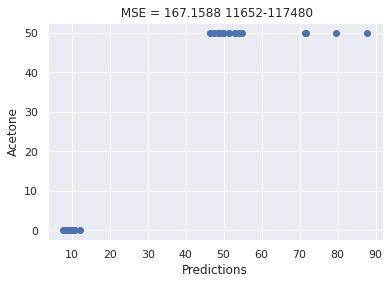

In [21]:
plot_title = '11652-117480'
def create_base_network(input_trace_shape, embedding_size):
    #def create_base_network(input_trace_shape, input_metadata_shape, embedding_size):
     """
     Base network to be shared (eq. to feature extraction).
     """
     input_trace = Input(shape=input_trace_shape)
     #input_metadata = Input(shape = input_metadata_shape)
     #input_sensor = Input(shape=input_sensor_shape)
     #input_peak = Input(shape = input_peak_shape)
     #peak = BatchNormalization()(input_peak)

     x = Convolution1D(filters = 16, kernel_size = 6, strides = 2, activation='relu')(input_trace)
     x = Convolution1D(filters = 32, kernel_size = 6, strides = 2, activation='relu')(x)
     x = Convolution1D(filters = 64, kernel_size = 6, strides = 2, activation='relu')(x)
     x = Convolution1D(filters = 128, kernel_size = 6, strides = 2, activation='relu')(x)
     #x = Convolution1D(filters = 256, kernel_size = 6, strides = 2, activation='relu')(x)
     x = MaxPooling1D(pool_size=2)(x)
     x = Flatten()(x)
     x = Dense(32, activation='relu')(x)
     x = Dense(32, activation = 'relu')(x)
     #xm = concatenate([x, input_metadata], axis = -1)
     #xm = Dense(32, activation='relu')(xm)
     #xm = Dense(32, activation = 'relu')(xm)
     #embedding = concatenate([x, peak], axis = -1)
     embedding = Dense(embedding_size, activation = 'relu', name = 'single_embedding')(x)

     #embedding_plus_peak = concatenate([embedding, peak], axis = -1)
    # embedding = Dense(embedding_size, activation = 'relu')(embedding_plus_peak)

     #Acetone head
     Ac_head = Dense(32, activation = 'relu', name = 'Ac_head')(embedding)
     Ac_head = Dense(16, activation = 'relu')(Ac_head)
     predAc = Dense(1, activation= 'linear', name = 'Ac_prediction_output')(Ac_head)


     #merged = concatenate([mergedpred, embedding], axis = -1)
     base_network = Model(inputs=[input_trace], outputs=[predAc, embedding])

     return base_network

# THIS IS TO RUN WITH REAL DATA EMBEDDING
real_test_model = create_base_network((7500,1), 
                                     embedding_size=32)
#for layer_target, layer_source in zip(real_test_model.layers, model.layers):
for layer_target, layer_source in zip(real_test_model.layers, real_model.layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights




predictions, embeddings = real_test_model.predict([real_data_dict['csvs']])
real_data_pred_Ac = predictions[:,:1]

ace_mse = mean_squared_error(real_data_dict['Ac'],real_data_pred_Ac)



plt.figure()
plt.ylabel('Acetone')
plt.xlabel('Predictions')
plt.title(' MSE = ' + str(round(ace_mse,4)) + ' ' + plot_title)

plt.scatter(real_data_pred_Ac, real_data_dict['Ac'])

plt.show()



In [22]:
def dotplot2(x1, y1):

    multi_data = {'y1':y1,
                  'x1':x1,
                  'Test': real_data_dict['testnum'],
                  'Acetone': real_data_dict['Ac'],
                  'CO2': real_data_dict['CO2'],
                  'temp': real_data_dict['temp'],                 
                 }
    multi_source = ColumnDataSource(multi_data)
    q1 = figure(plot_width=400, plot_height=350,toolbar_location = "left",
              x_axis_label = "Real Acetone",
              y_axis_label = "Predicted Acetone")
    q1.circle(x='x1', y='y1', source=multi_source)
    q1.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('Test', '@Test'),
        ('Acetone', '@Acetone'),
        ('temp', '@temp'),
        ('CO2', '@CO2')
        ]))

    q1.border_fill_color = "white"
    q1.min_border_top = 20

    output_notebook()
    show(q1)



dotplot2(real_data_pred_Ac, real_data_dict['Ac'])


In [ ]:
  with open(pickle_path +'/real_data_dict_24_11252-11460.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)


  print(np.array(ddict['csvs']).shape)

(0,)


In [ ]:

  with open(pickle_path +'/real_data_24_11252-11460.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, rco2, real_model = rmodel.run_realdata_check(code +'_11252-11460', ddict, rep_model)
  co2_11252_to_11460.append(rco2)
  ac_11252_to_11460.append(race)


  with open(pickle_path +'/real_data_24_11460-11651.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, rco2, real_model = rmodel.run_realdata_check(code +'_11460-11652', ddict, rep_model)
  co2_11460_to_11652.append(rco2)
  ac_11460_to_11652.append(race)

  with open(pickle_path +'/real_data_24_11651-11748.pickle', 'rb') as handle:
    
    ddict = pickle.load(handle)
  race, rco2, real_model = rmodel.run_realdata_check(code +'_11652-11748', ddict, rep_model)
  co2_11652_to_11748.append(rco2)
  ac_11652_to_11748.append(race)


## 4) Test the Model 

#### Test the network by making an untrained copy (creating empty network, "testing_embeddings" and getting results "pretrain_pred"). This is to get the predictions for an untrained version of the model.

#### THEN grab the weights from the model trained using our quad loss to generate "trained embedding results " ("posttrain_pred")

#### **This uses data from the fake test set (not seen by the model during training)**

In [ ]:
#option to save the weights
#option to save the weights
nonet_model_name = '1000_4000_'+ str(sensor_of_interest)
model_name = nonet_model_name + '_csv_only'
test_model.save(checkpoint_path + '/weights/' + model_name + '.hdf5')


test_model.save(checkpoint_path + '/save_models/' + model_name)

NameError: ignored

### Testing model on real data

## IF YOU WANT TO READ FROM A PICKLE, SKIP TO STEP **"START HERE TO READ FROM PICKLE"**

## **START HERE TO READ FROM PICKLE**

In [ ]:
# To load real data pickle
sos = '24'
embed_code = 'G5c'

with open(pickle_path +'/real_data_24_11252-11461.pickle', 'rb') as handle:
    


    
    real_data_dict = pickle.load(handle)
print(real_data_dict.keys())

dict_keys(['testnum', 'csvs', 'Ac', 'CO2', 'temp', 'sensor', 'metadata', 'peak_pos', 'peak_pos_t', 'peak_neg', 'peak_neg_t'])


In [ ]:
nonet_model_name = 'No 1.5 or 3 ppm Acetone'

In [ ]:
# To load embeddings for input
with open(pickle_path +'/avg_embeddings_from_real_data_all_sensors.pickle', 'rb') as handle:
    
    predicted_embedding_source = pickle.load(handle)
print(predicted_embedding_source.keys())

dict_keys(['testnum', 'csvs', 'Ac', 'CO2', 'temp', 'metadata', 'peak_pos', 'peak_pos_t', 'peak_neg', 'peak_neg_t'])


In [ ]:
#This is to add the embedding
add_embed_list = []



for i in range(0,len(real_data_dict['csvs'])):

    add_embed_list.append(predicted_embedding_source['FakeTrain_RealPred ' + sos + '_w_ratio_' + embed_code])

real_data_dict['predicted_sensor'] = np.array(add_embed_list)



In [ ]:
if scale_factor == 'log':
  real_data_dict['CO2_to_use'] = np.log(real_data_dict['CO2'])
else:
  real_data_dict['CO2_to_use'] = real_data_dict['CO2']

In [ ]:
# This is to add the peak data
peaks_list = []
for j in range(0, len(real_data_dict['csvs'])):
  peaks_list.append([real_data_dict['peak_pos'][j], real_data_dict['peak_pos_t'][j], real_data_dict['peak_neg'][j], real_data_dict['peak_neg_t'][j]])
real_data_dict['peaks'] = np.array(peaks_list)
print(real_data_dict['peaks'].shape)
print(real_data_dict['peaks'][0])

(126, 4)
[  21   15 -201    2]


In [ ]:
real_model.summary()

Model: "model_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           [(None, 7500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_348 (Conv1D)             (None, 3748, 16)     112         input_88[0][0]                   
__________________________________________________________________________________________________
conv1d_349 (Conv1D)             (None, 1872, 32)     3104        conv1d_348[0][0]                 
__________________________________________________________________________________________________
conv1d_350 (Conv1D)             (None, 934, 64)      12352       conv1d_349[0][0]                 
___________________________________________________________________________________________

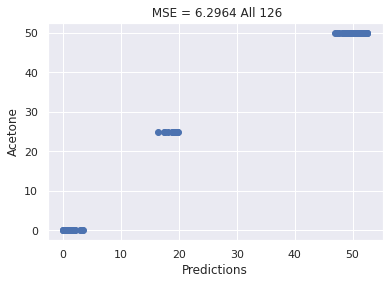

In [ ]:
plot_title = 'All 126'
def create_base_network(input_trace_shape, embedding_size):
    #def create_base_network(input_trace_shape, input_metadata_shape, embedding_size):
     """
     Base network to be shared (eq. to feature extraction).
     """
     input_trace = Input(shape=input_trace_shape)
     #input_metadata = Input(shape = input_metadata_shape)
     #input_sensor = Input(shape=input_sensor_shape)
     #input_peak = Input(shape = input_peak_shape)
     #peak = BatchNormalization()(input_peak)

     x = Convolution1D(filters = 16, kernel_size = 6, strides = 2, activation='relu')(input_trace)
     x = Convolution1D(filters = 32, kernel_size = 6, strides = 2, activation='relu')(x)
     x = Convolution1D(filters = 64, kernel_size = 6, strides = 2, activation='relu')(x)
     x = Convolution1D(filters = 128, kernel_size = 6, strides = 2, activation='relu')(x)
     #x = Convolution1D(filters = 256, kernel_size = 6, strides = 2, activation='relu')(x)
     x = MaxPooling1D(pool_size=2)(x)
     x = Flatten()(x)
     x = Dense(32, activation='relu')(x)
     x = Dense(32, activation = 'relu')(x)
     #xm = concatenate([x, input_metadata], axis = -1)
     #xm = Dense(32, activation='relu')(xm)
     #xm = Dense(32, activation = 'relu')(xm)
     #embedding = concatenate([x, peak], axis = -1)
     embedding = Dense(embedding_size, activation = 'relu', name = 'single_embedding')(x)

     #embedding_plus_peak = concatenate([embedding, peak], axis = -1)
    # embedding = Dense(embedding_size, activation = 'relu')(embedding_plus_peak)

     #Acetone head
     Ac_head = Dense(32, activation = 'relu', name = 'Ac_head')(embedding)
     Ac_head = Dense(16, activation = 'relu')(Ac_head)
     predAc = Dense(1, activation= 'linear', name = 'Ac_prediction_output')(Ac_head)
      #CO2 head


       #Merge the embeddings and predictions as a single ouptut of the form (Acetone_prediction, CO2_prediction, embedding)


     #merged = concatenate([mergedpred, embedding], axis = -1)
     base_network = Model(inputs=[input_trace], outputs=[predAc, embedding])

     return base_network

# THIS IS TO RUN WITH REAL DATA EMBEDDING
real_test_model = create_base_network((7500,1), 
                                     embedding_size=32)
#for layer_target, layer_source in zip(real_test_model.layers, model.layers):
for layer_target, layer_source in zip(real_test_model.layers, real_model.layers):
    weights = layer_source.get_weights()
    layer_target.set_weights(weights)
    del weights




predictions, embeddings = real_test_model.predict([real_data_dict['csvs']])
real_data_pred_Ac = predictions[:,:1]



ace_mse = mean_squared_error(real_data_dict['Ac'],real_data_pred_Ac)



plt.figure()
plt.ylabel('Acetone')
plt.xlabel('Predictions')
plt.title(' MSE = ' + str(round(ace_mse,4)) + ' ' + plot_title)

plt.scatter(real_data_pred_Ac, real_data_dict['Ac'])

plt.show()


In [ ]:
def dotplot2(x1, y1):

    multi_data = {'y1':y1,
                  'x1':x1,

                  'Test': real_data_dict['testnum'],
                  'Acetone': real_data_dict['Ac'],
                  'CO2': real_data_dict['CO2'],
                  'temp': real_data_dict['temp'],                 
                 }
    multi_source = ColumnDataSource(multi_data)
    q1 = figure(plot_width=400, plot_height=350,toolbar_location = "left",
              x_axis_label = "Predicted Acetone",
              y_axis_label = "Real Acetone")
    q1.circle(x='x1', y='y1', source=multi_source)
    q1.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('Test', '@Test'),
        ('Acetone', '@Acetone'),
        ('temp', '@temp'),
        ('CO2', '@CO2')
        ]))

    q1.border_fill_color = "white"
    q1.min_border_top = 20

    output_notebook()
    show(q1)



dotplot2(real_data_pred_Ac, real_data_dict['Ac'])


In [ ]:
def dotplot2(x1, y1):

    multi_data = {'y1':y1,
                  'x1':x1,

                  'Test': real_data_dict['testnum'],
                  'Acetone': real_data_dict['Ac'],
                  'CO2': real_data_dict['CO2'],
                  'temp': real_data_dict['temp'],                 
                 }
    multi_source = ColumnDataSource(multi_data)
    q1 = figure(plot_width=400, plot_height=350,toolbar_location = "left",
              x_axis_label = "Predicted Acetone",
              y_axis_label = "Real Acetone")
    q1.circle(x='x1', y='y1', source=multi_source)
    q1.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('Test', '@Test'),
        ('Acetone', '@Acetone'),
        ('temp', '@temp'),
        ('CO2', '@CO2')
        ]))

    q1.border_fill_color = "white"
    q1.min_border_top = 20

    output_notebook()
    show(q1)



dotplot2(real_data_pred_Ac, real_data_dict['Ac'])


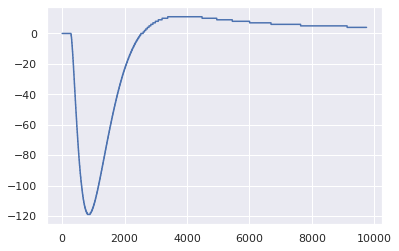

In [ ]:
foo = np.array(real_data_dict['X_real'][:1])
reshapedfoo = foo.reshape((9750))
plt.plot(reshapedfoo)
#plt.xlim([0,500])

# 5) Saving the model 

## The MODEL DIR must unfortunately be stored outside of the drive, so you **MUST** remember to drag the folder into "My Drive" before you close the session

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Checkpoints/save_models/all_sensor_model_csv_only_two_outputs/assets


In [ ]:
import os
!apt-get update && apt-get -qq install xxd

In [ ]:
# Define paths to model files

base_name = 'model_19_64'

MODELS_DIR = '64/'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
MODEL_TF = MODELS_DIR + base_name + '.pb'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + base_name + '_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + base_name + '_quant.tflite'
MODEL_TFLITE_DRQ = MODELS_DIR + base_name + '_DRQ_quant.tflite'
MODEL_TFLITE_FI = MODELS_DIR + base_name + '_FI_quant.tflite'
MODEL_TFLITE_F16 = MODELS_DIR + base_name + '_F16.tflite'

MODEL_TFLITE_MICRO = MODELS_DIR + base_name + '_no_quant.cc'
MODEL_TFLITE_MICRO_DRQ =MODELS_DIR + base_name + '_DRQ_quant.cc'
MODEL_TFLITE_MICRO_FI =MODELS_DIR + base_name + '_FI_quant.cc'
MODEL_TFLITE_MICRO_F16 =MODELS_DIR ++ base_name + '_F16.cc'

### This version of the model IS saved within the drive, so you can regain anything "lost" if you forgot to move the **MODELS DIR** folder back into the drive

In [ ]:
real_test_model.save(checkpoint_path + '/save_models/' + base_name)

In [ ]:
#real_test_model.save(MODEL_TF)
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
tflite_model = converter.convert()


# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_NO_QUANT_TFLITE, 'wb') as f:
  f.write(tflite_model)

# Convert to a C source file
!xxd -i {MODEL_NO_QUANT_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_NO_QUANT_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

## Quantization for model optimization: https://www.tensorflow.org/lite/performance/post_training_quantization





**Dynamic range quantization**

The simplest form of post-training quantization statically quantizes only the weights from floating point to integer, which has 8-bits of precision:


At inference, weights are converted from 8-bits of precision to floating point and computed using floating-point kernels. This conversion is done once and cached to reduce latency.

To further improve latency, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inference. However, the outputs are still stored using floating point so that the speedup with dynamic-range ops is less than a full fixed-point computation.

In [ ]:
#real_test_model.save(MODEL_TF)
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()


# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_DRQ, 'wb') as f:
  f.write(tflite_quant_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_DRQ} > {MODEL_TFLITE_MICRO_DRQ}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_DRQ.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_DRQ}

Float16 conversion

In [ ]:
#real_test_model.save(MODEL_TF)
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()



# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_F16, 'wb') as f:
  f.write(tflite_quant_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_F16} > {MODEL_TFLITE_MICRO_F16}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_F16.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_F16}

**Full integer quantization**
You can get further latency improvements, reductions in peak memory usage, and compatibility with integer only hardware devices or accelerators by making sure all model math is integer quantized.

For full integer quantization, you need to measure the dynamic range of activations and inputs by supplying sample input data to the converter. Refer to the representative_dataset_gen() function used in the following code.

Integer with float fallback (using default float input/output)
In order to fully integer quantize a model, but use float operators when they don't have an integer implementation (to ensure conversion occurs smoothly), use the following steps:

In [ ]:
def representative_dataset():
  for i in range(125):
   

    yield([real_data_dict['X_real'][i].reshape(1,7500,1)])

**Full int quantization -- Int with float fallback**

In [ ]:
fmodel = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = fmodel.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])


#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.int32]
tflite_quant_FI_model = converter.convert()




# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_FI, 'wb') as f:
  f.write(tflite_quant_FI_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_FI} > {MODEL_TFLITE_MICRO_FI}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_FI.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_FI}

**Full int quantization -- Full int quantization**
NOT WORKING

In [ ]:
#Save the model using Integrer only 
#This doesn't work
real_test_model = tf.saved_model.load(checkpoint_path + '/practice_save/' + base_name)
concrete_func = real_test_model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([None, 7500, 1])

#convert model to TF Lite
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization (except inputs/outputs which are always float)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset

converter.target_spec.supported_types = [tf.int8]
#converter.inference_input_type = tf.int8

tflite_quant_FI_model = converter.convert()




# Save the TF Lite model.
with tf.io.gfile.GFile(MODEL_TFLITE_FI, 'wb') as f:
  f.write(tflite_quant_FI_model)

# Convert to a C source file
!xxd -i {MODEL_TFLITE_FI} > {MODEL_TFLITE_MICRO_FI}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE_FI.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO_FI}

ValueError: ignored

### Check density of metadata

In [ ]:

import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def make_db_get_test_list (df, Acetone, CO2, H2O, Sensor, Range1, Range2):
    
    if Sensor == 'all':
        filtered = df
    else:
        filtered = df.query('Sensor == @Sensor')
    if Acetone != 'all':
        if str(Acetone)[:1] == '<':
            comp = float(Acetone[1:])
            filtered = filtered.query('Acetone < @comp')
        else:
            if str(Acetone)[:1] == '>':
                comp = float(Acetone[1:])
                filtered = filtered.query('Acetone > @comp')
            else:
                filtered = filtered.query('Acetone == @Acetone')
    if CO2 != 'all':
        if CO2 == '+':
            filtered = filtered.query('CO2 != 0')
        else:
            if CO2 == 4:
                filtered = filtered.query('CO2 >= 40000 & CO2 <= 46666.67')
            else:
                if CO2 == 5:
                    filtered = filtered.query('CO2 > 46666.67 & CO2 <= 53333.33')
                else:
                    filtered = filtered.query('CO2 > 53333.33 & CO2 <= 60000')
    filtered = filtered.query('H2O == @H2O')
    filtered['Tests'] = filtered.index  
    list_of_tests = filtered['Tests'].tolist()
    #return([y for y in list_of_tests if ((int(y)>=Range1)&(int(y)<Range2))])
    return(filtered)

In [ ]:
db = make_db_get_test_list (test_db_df, 'all', '+', 10, 10, 800000, 1900000)

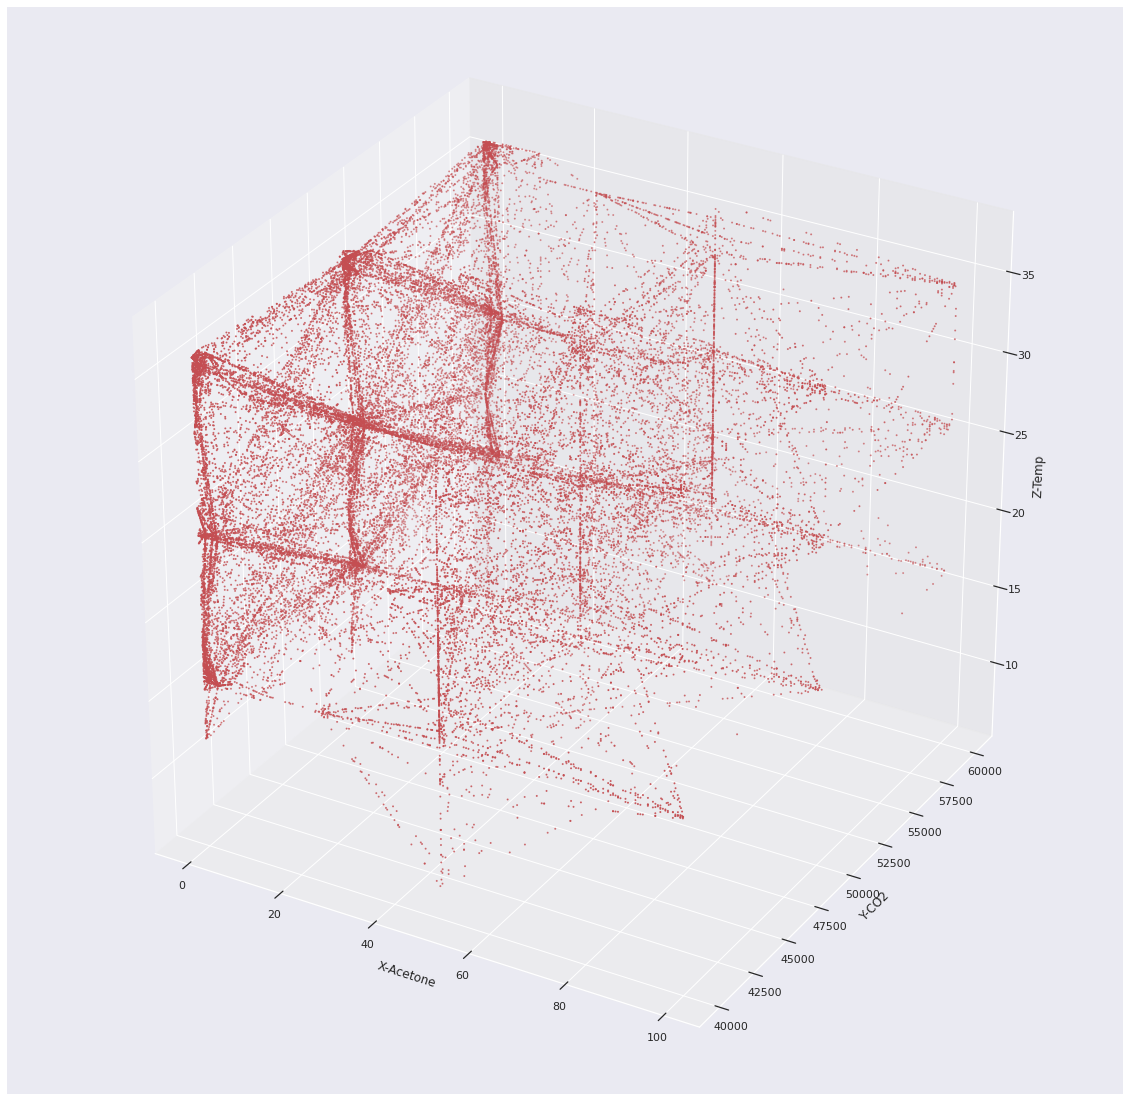

In [ ]:
X= db['Acetone']
Y =db['CO2']
Z =db['Instr_Temp']

# plot points and fitted surface
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(X, Y, Z, c='r', s=1)
plt.xlabel('X-Acetone')
plt.ylabel('Y-CO2')
ax.set_zlabel('Z-Temp')
ax.axis('tight')
plt.show()